**Process:**
* Load and check data
* Data preprocess (2 datasets)
* Answer each question (7 in total)
 
**Notations:**

*stock.sas7bdat*
* PERMNO: a 5-digit firm identifier
* DATE: last trading day of the month, SAS format yymmddn8.
* COMNAM: company name
* EXCHCD: 1: NYSE, 2: AMEX, 3: NASDAQ
* SICCD: 4 digit SIC code
* PRC: closing price
* RET: monthly return
* SHROUT: shares outstanding in thousand shares

*ff3.sas7bdat*
* DATE: last trading day of the month
* SMB: small-minus-big return
* HML: high-minus-low return
* MKTRF: excess return on the market
* RF: risk-free rate
* UMD: momentum factor

In [1]:
# import packages
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from scipy.stats import t
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib

Using matplotlib backend: Qt5Agg


# Load and check data

In [2]:
# load data
Stock = pd.read_sas("stock.sas7bdat")
RM = pd.read_sas("ff3.sas7bdat")

In [3]:
# show first few rows of Stock
Stock.head()

,PERMNO,DATE,COMNAM,EXCHCD,SICCD,PRC,RET,SHROUT
0,10001.0,2001-01-31,b'ENERGY WEST INC',3.0,4920.0,9.875,0.012821,2498.0
1,10001.0,2001-02-28,b'ENERGY WEST INC',3.0,4920.0,9.750,-0.012658,2504.0
2,10001.0,2001-03-30,b'ENERGY WEST INC',3.0,4920.0,10.000,0.038462,2509.0
3,10001.0,2001-04-30,b'ENERGY WEST INC',3.0,4920.0,9.750,-0.025000,2509.0
4,10001.0,2001-05-31,b'ENERGY WEST INC',3.0,4920.0,10.700,0.097436,2509.0


In [4]:
# show first few rows of RM
RM.head()

,DATE,SMB,HML,MKTRF,RF,UMD
0,2001-01-31 00:08:15.763200,0.0657,-0.0490,0.0313,0.0054,-0.2506
1,2001-02-28 00:07:53.644800,-0.0074,0.1290,-0.1005,0.0038,0.1251
2,2001-03-30 00:00:00.000000,0.0034,0.0645,-0.0726,0.0042,0.0835
3,2001-04-30 00:08:15.590400,0.0052,-0.0469,0.0794,0.0039,-0.0797
4,2001-05-31 00:00:00.000000,0.0260,0.0314,0.0072,0.0032,0.0212


In [5]:
# select the columns we want
Stock = Stock[["DATE", "PERMNO", "PRC", "RET", "SHROUT"]]
RM = RM[["DATE", "MKTRF", "RF"]]

In [6]:
# check Stock's information
Stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895867 entries, 0 to 895866
Data columns (total 5 columns):
DATE      895867 non-null datetime64[ns]
PERMNO    895867 non-null float64
PRC       889427 non-null float64
RET       885676 non-null float64
SHROUT    894897 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 34.2 MB


In [7]:
# check RM's information
RM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 3 columns):
DATE     204 non-null datetime64[ns]
MKTRF    204 non-null float64
RF       204 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.9 KB


From the information above, we can find that DATE column in both datasets is already datetime object, other columns are float.

# Data preprocess (2 datasets)

### First, deal with Stock

In [8]:
# create temporary Stock dataset betweeen 2008/01/01 and 2012/12/31
temp_Stock = Stock[(Stock.DATE > "2008/01/01") & (Stock.DATE <= "2012/12/31")]

# create function to count observations for each company
def calculate_num(input_data, num):
    temp_data = input_data.sort_values("DATE", ascending=True)
    # find out last row of data's DATE, and transform it to string
    # beacuse we need to make sure companies still exist at 2012/12/31
    last_date = str(temp_data.iloc[-1, :]["DATE"].date())
    # create index to find non na data point according to RET
    na_index = temp_data.RET.isna() == False
    # select data without na
    temp_data = temp_data[na_index]
    # count observations from back to front
    # the observations need at least 36 data points
    if len(temp_data.iloc[-num:, ]) == num and last_date == "2012-12-31":
        return True
    else:
        return False
    
# group temp_Stock by "PERMNO" column, and apply "calculate_num" function to each group
count_result = temp_Stock.groupby("PERMNO").apply(lambda x: calculate_num(x, 36))

# save company's PERMNO if it met the requirement
target_PERMNO = count_result[count_result == True].index

# show the number of companies which meet the requirement
print("Number of qualified companies:", len(target_PERMNO))

Number of qualified companies: 3238


In [9]:
# transform target_PERMNO to set
target_PERMNO = set(list(map(lambda x:str(int(x)), target_PERMNO)))

# transform Stock's PERMNO column to string
# in case of warnings, set a copy of Stock
Stock = Stock.copy()
Stock.PERMNO = Stock.PERMNO.apply(lambda x: str(int(x)))

# create index to find whether Stock's PERMNO is in target_PERMNO
selected_index = Stock.PERMNO.apply(lambda x: x in target_PERMNO)

# select companies which meet the requirement
Stock = Stock[selected_index]

### Second, merge Stock with RM

In [10]:
# check the key we need while merging two dataframes
print("Stock's DATE format:", Stock.DATE.iloc[0])
print("RM's DATE format:", RM.DATE.iloc[0])

Stock's DATE format: 2001-01-31 00:00:00
RM's DATE format: 2001-01-31 00:08:15.763200


From the information above, we can find that RM's DATE format also contain hour, minute, and second. However, Stock's DATE format doesn't contain those information, so we need to unify their format.

In [11]:
# unify their DATE format by only selecting year, month, and day
# in case of warnings, set a copy of temp_Stock
Stock = Stock.copy()
Stock["DATE"] = Stock["DATE"].apply(lambda x:x.date())
RM["DATE"] = RM["DATE"].apply(lambda x:x.date())

# merge Stock with RM
Sample = Stock.merge(RM, how="inner", on="DATE")

# create new column "RIRF" for excess return on market
Sample["RIRF"] = Sample["RET"] - Sample["RF"]

In [12]:
datetime.strptime("2008-01-01", "%Y-%m-%d")

datetime.datetime(2008, 1, 1, 0, 0)

In [13]:
# define function to run regression
def run_regression(x, y):
    X = add_constant(x)
    Y = y
    model = OLS(Y, X, missing="drop")
    result = model.fit()
    params = pd.DataFrame(result.params).T
    params.columns = ["Alpha", "Beta"]
    t_value = pd.DataFrame(result.tvalues).T
    t_value.columns = ["Alpha_t_value", "Beta_t_value"]
    p_value = pd.DataFrame(result.pvalues).T
    p_value.columns = ["Alpha_p_value", "Beta_p_value"]
    std_err = pd.DataFrame(result.bse).T
    std_err.columns = ["Alpha_std_err", "Beta_std_err"]
    return params.join(t_value).join(p_value).join(std_err)

# select the time frame which we are going to run regression
date_start = datetime.strptime("2008/01/01", "%Y/%m/%d").date()
date_end = datetime.strptime("2012/12/31", "%Y/%m/%d").date()
temp_Sample = Sample[(Sample.DATE > date_start) & (Sample.DATE <= date_end)]

# group Sample by "PERMNO" column, and apply "run_regression" function to each group
reg_result = temp_Sample.groupby("PERMNO").apply(lambda x: run_regression(x.MKTRF, x.RIRF))

# show first few rows of regression result
reg_result.head()

,,Alpha,Beta,Alpha_t_value,Beta_t_value,Alpha_p_value,Beta_p_value,Alpha_std_err,Beta_std_err
PERMNO,,,,,,,,,
10001,0,0.005097,0.317924,0.594660,2.075380,0.554383,0.042396,0.008571,0.153188
10002,0,-0.005789,0.033948,-0.232718,0.076360,0.816800,0.939395,0.024875,0.444573
10025,0,0.014156,1.247654,1.026318,5.061327,0.309003,0.000004,0.013793,0.246507
10026,0,0.013196,0.691046,1.553259,4.551429,0.125801,0.000028,0.008495,0.151831
10028,0,0.011520,1.405295,0.525471,3.742407,0.601533,0.000464,0.021924,0.375506


**How we select sotcks:**
1. We need to select stocks whose $\beta$ closes to one, so we need to make sure the stocks' $\beta$ which we gonna select are significant. As a result, we select stocks whose p value of $\beta$ is smaller than 0.05.
2. Then we pick stocks whose $\beta$ lies between 0.9 and 1.1.
3. Finally, we sort the selected stocks in ascending and descending way according to each stock's $\alpha$, and select top 25 five stocks sequentially to form small and big $\alpha$ portfolio.

In [14]:
# step 1
stock_pool = reg_result[reg_result.Beta_p_value <= 0.05]
print("Number of stocks after first filtration: ", len(stock_pool))

# step 2
stock_pool = stock_pool[(stock_pool.Beta >= 0.8) & (stock_pool.Beta <= 1.2)]
print("Number of stocks after second filtration: ", len(stock_pool))

# step 3
small_alpha = stock_pool.sort_values("Alpha", ascending=True).iloc[:25, ]
big_alpha =  stock_pool.sort_values("Alpha", ascending=False).iloc[:25, ]

Number of stocks after first filtration:  2826
Number of stocks after second filtration:  744


# Answer each question (7 in total)

### 1. Make a table to show the $\alpha$ and $\beta$ of the stocks you pick for these two portfolios with data from the 2008-2012 estimation period. Please include the standard deviations of your parameters as well.

**Table for small alpha portfolio:**

In [15]:
result = small_alpha[["Alpha", "Beta", "Alpha_std_err", "Beta_std_err"]]
result

,,Alpha,Beta,Alpha_std_err,Beta_std_err
PERMNO,,,,,
87337,0,-0.048067,1.089437,0.028216,0.504273
90640,0,-0.044021,1.119909,0.018091,0.323321
88572,0,-0.039867,1.189086,0.032221,0.575845
93128,0,-0.034293,1.145799,0.012203,0.266196
44951,0,-0.031884,1.156390,0.018594,0.332315
90964,0,-0.029293,1.199025,0.019477,0.348100
11513,0,-0.027248,0.984010,0.022763,0.406827
92935,0,-0.025320,0.962562,0.020286,0.442739
83704,0,-0.025193,0.892579,0.018675,0.323887


**Table for big alpha portfolio:**

In [16]:
result = big_alpha[["Alpha", "Beta", "Alpha_std_err", "Beta_std_err"]]
result

,,Alpha,Beta,Alpha_std_err,Beta_std_err
PERMNO,,,,,
79588,0,0.042315,1.027434,0.025369,0.453398
76614,0,0.041599,1.080628,0.019969,0.356878
88208,0,0.039476,1.170401,0.032026,0.572360
81084,0,0.037965,1.126172,0.026290,0.469860
83633,0,0.037962,1.151116,0.020971,0.374800
88167,0,0.036096,1.132384,0.014092,0.251854
91899,0,0.035274,0.996847,0.017528,0.313268
77289,0,0.033513,0.837130,0.021990,0.389864
45225,0,0.033167,0.978704,0.026237,0.468912


### 2. Please report the summary statistics of the returns on the two portfolios you constructed as well as the market portfolio (RM) and riskfree asset returns (RF). Use the sample period from 2008 to 2012 for this question. Some of the stocks might not have 5 year full history here, you are allowed to have a portfolio with less than 25 stocks for earlier months. What you need to present are mean, standard deviation, minimum, and maximum of the returns. Please note that RM = MKTRF + RF.

**Define function to deal with data:**

In [17]:
# define function to shift MKTCAP
def shift_MKTCAP(data):
    data = data.copy()
    data.sort_values("DATE", inplace=True)
    shifted_data = data.shift()
    selected_column = pd.DataFrame(shifted_data["MKTCAP"])
    selected_column.rename(columns={"MKTCAP": "LMKTCAP"}, inplace=True)
    return pd.concat([data, selected_column], axis=1)

# define finction to calculate weights
def calcuate_weight(data):
    weights = data["LMKTCAP"] / sum(data["LMKTCAP"])
    weights = pd.DataFrame(weights)
    weights.rename(columns={"LMKTCAP": "WGT"}, inplace=True)
    return pd.concat([data, weights], axis=1)

**Deal with small $\alpha$ portfolio:**

In [18]:
# create list for small alpha portfolio
small_alpha_list = small_alpha.index.get_level_values(0)

# create index to find stocks from "Sample" dataset for small alpha stocks
small_alpha_index = Sample.PERMNO.apply(
    lambda x: x in set(small_alpha.index.get_level_values(0))
)

# create dataset "small_alpha_stocks"
small_alpha_stocks = Sample[small_alpha_index]

# create new column "MKTCAP" to store market cap
small_alpha_stocks = small_alpha_stocks.copy()
small_alpha_stocks["MKTCAP"] = small_alpha_stocks["PRC"] * small_alpha_stocks["SHROUT"]

# group small_alpha_stocks by "PERMNO" column, and apply "shift_MKTCAP" function to each group
small_alpha_stocks = small_alpha_stocks.groupby("PERMNO").apply(
    lambda x:shift_MKTCAP(x)
)

# ungroup small_alpha_stocks 
# drop "PERMNO" column first, so it could put the group key "PERMNO" back to the column
small_alpha_stocks = small_alpha_stocks.drop("PERMNO", axis=1).reset_index(level=False)

# group small_alpha_stocks by "DATE" column, and apply "calcuate_weight" function to each group
small_alpha_stocks = small_alpha_stocks.dropna().groupby("DATE").apply(
    lambda x: calcuate_weight(x)
)

# calculate each stock's return according to its weight
small_alpha_stocks["VWPRet"] = small_alpha_stocks["RET"] * small_alpha_stocks["WGT"]

# calculate portfolio's return according to each time frame
small_alpha_return = small_alpha_stocks.groupby("DATE").sum()["VWPRet"]
small_alpha_return = pd.DataFrame(small_alpha_return)

**Deal with big 𝛼 portfolio:**

In [19]:
# create list for big alpha portfolio
big_alpha_list = big_alpha.index.get_level_values(0)

# create index to find stocks from "Sample" dataset for big alpha stocks
big_alpha_index = Sample.PERMNO.apply(
    lambda x: x in set(big_alpha.index.get_level_values(0))
)

# create dataset "big_alpha_stocks"
big_alpha_stocks = Sample[big_alpha_index]

# create new column "MKTCAP" to store market cap
big_alpha_stocks = big_alpha_stocks.copy()
big_alpha_stocks["MKTCAP"] = big_alpha_stocks["PRC"] * big_alpha_stocks["SHROUT"]

# group big_alpha_stocks by "PERMNO" column, and apply "shift_MKTCAP" function to each group
big_alpha_stocks = big_alpha_stocks.groupby("PERMNO").apply(
    lambda x:shift_MKTCAP(x)
)

# ungroup big_alpha_stocks 
# drop "PERMNO" column first, so it could put the group key "PERMNO" back to the column
big_alpha_stocks = big_alpha_stocks.drop("PERMNO", axis=1).reset_index(level=False)

# group big_alpha_stocks by "DATE" column, and apply "calcuate_weight" function to each group
big_alpha_stocks = big_alpha_stocks.dropna().groupby("DATE").apply(
    lambda x: calcuate_weight(x)
)

# calculate each stock's return according to its weight
big_alpha_stocks["VWPRet"] = big_alpha_stocks["RET"] * big_alpha_stocks["WGT"]

# calculate portfolio's return according to each time frame
big_alpha_return = big_alpha_stocks.groupby("DATE").sum()["VWPRet"]
big_alpha_return = pd.DataFrame(big_alpha_return)

**Prepare summary statistics for small $\alpha$ portfolio:**

In [20]:
# calculate market portfolio's return
RM["RM"] = RM["RF"] + RM["MKTRF"]

# create "DATE" column(key) to merge "small_alpha_return" and "RM"
small_alpha_return["DATE"] = small_alpha_return.index

# merge "small_alpha_return" and "RM"
small_alpha_result = small_alpha_return.merge(RM, on="DATE")

# select data which lie between 2008/1/1~2012/12/31
small_alpha_temp_return = small_alpha_result[(small_alpha_result.DATE > date_start) & 
                                             (small_alpha_result.DATE <= date_end)]

# drop redundant column
small_alpha_temp_return = small_alpha_temp_return.drop(["DATE", "MKTRF"], axis=1)

# rename columns
small_alpha_temp_return.columns = ["Small alpha portfolio", "Risk free rate", "Market portfolio"]

**Prepare summary statistics for big $\alpha$ portfolio:**

In [21]:
# create "DATE" column(key) to merge "big_alpha_return" and "RM"
big_alpha_return["DATE"] = big_alpha_return.index

# merge "big_alpha_return" and "RM"
big_alpha_result = big_alpha_return.merge(RM, on="DATE")

# select data which lie between 2008/1/1~2012/12/31
big_alpha_temp_return = big_alpha_result[(big_alpha_result.DATE > date_start) & 
                                             (big_alpha_result.DATE <= date_end)]

# drop redundant column
big_alpha_temp_return = big_alpha_temp_return.drop(["DATE", "MKTRF"], axis=1)

# rename columns
big_alpha_temp_return.columns = ["Big alpha portfolio", "Risk free rate", "Market portfolio"]

**Summary statistics for big, small $\alpha$ portfolio, market portfolio, and risk free rate:**

In [22]:
result = pd.concat([small_alpha_temp_return.describe(), 
                    big_alpha_temp_return.describe()], axis=1)

result = result[["Big alpha portfolio", "Small alpha portfolio", 
                 "Market portfolio", "Risk free rate"]]

result.T.drop_duplicates()

,count,mean,std,min,25%,50%,75%,max
Big alpha portfolio,60.0,0.026257,0.074591,-0.166426,-0.022723,0.027346,0.070567,0.173332
Small alpha portfolio,60.0,-0.016681,0.086536,-0.249492,-0.070752,-0.012585,0.044150,0.176125
Market portfolio,60.0,0.003395,0.056189,-0.171500,-0.026825,0.009900,0.038900,0.113500
Risk free rate,60.0,0.000312,0.000579,0.000000,0.000000,0.000100,0.000100,0.002100


### 3. Please proceed with the stocks you picked to construct those two portfolios for the 2013-2017 period. Report your portfolio $\alpha$ and $\beta$ for this period and discuss whether your $\alpha$ is still significant and whether your $\beta$ remains insignificantly different from 1 for each portfolio.

**Define function for hypothesis testing:**

In [23]:
def hypothesis_testing(data):
    # calculate t value for the hypothesis testing for Beta(different from 1 or not)
    Beta_t_value = (data["Beta"] - 1) / data["Beta_std_err"]
    # transform the t value above to p value
    Beta_p_value = t.sf(np.abs(Beta_t_value), len(reg_early)-1)
    # prepare result for hypothesis testing
    result = pd.concat([pd.DataFrame(data[["Alpha", "Beta", "Alpha_p_value"]]),
                        pd.DataFrame([Beta_p_value])], axis=1)
    # rename column
    result.rename(columns={0: "Beta_p_value"}, inplace=True)
    return result

**Run regression with small $\alpha$ portfolio:**

In [24]:
# create new column "RIRF" for excess return on market
small_alpha_result["RIRF"] = small_alpha_result["VWPRet"] - small_alpha_result["RF"]

# select data which lie between 2008/01/01 and 2012/12/31
date_start = datetime.strptime("2008/01/01", "%Y/%m/%d").date()
date_end = datetime.strptime("2012/12/31", "%Y/%m/%d").date()
reg_early = small_alpha_result[(small_alpha_result.DATE > date_start) & 
                               (small_alpha_result.DATE <= date_end)]

# select data which lie between 2013/01/01 and 2017/12/31
date_start = datetime.strptime("2013/01/01", "%Y/%m/%d").date()
date_end = datetime.strptime("2017/12/31", "%Y/%m/%d").date()
reg_later = small_alpha_result[(small_alpha_result.DATE > date_start) &
                               (small_alpha_result.DATE <= date_end)]

# run regression for different time frame
reg_early_result = run_regression(reg_early.MKTRF, reg_early.RIRF)
reg_later_result = run_regression(reg_later.MKTRF, reg_later.RIRF)

**Prepare hypothesis testing for small alpha portfolio:**

In [25]:
# run hypothesis for different time frame
early_result = hypothesis_testing(reg_early_result)
later_result = hypothesis_testing(reg_later_result)
result = pd.concat([early_result, later_result]).T

#rename column
result.columns = ["2008~2012", "2013~2017"]
result.T

,Alpha,Beta,Alpha_p_value,Beta_p_value
2008~2012,-0.020303,1.073664,0.014724,0.305827
2013~2017,-0.000002,1.730446,0.999841,0.007823


**Under 95% confidence level, null hypothesis and alternative hypothesis for $\alpha$ and $\beta$:**

$\alpha$:

${H_0}$ : $\alpha$ = 0

${H_1}$ : $\alpha$ $\neq$ 0

$\beta$:

${H_0}$ : $\beta$ = 1

${H_1}$ : $\beta$ $\neq$ 1

From the table above, we find that $\alpha$ is significantly different from 0, and $\beta$ is insignificantly different from 1 in 2008~2012, which has met our expectation. However, $\alpha$ is insignificantly different from 0, and $\beta$ is significantly different from 1 in 2013~2017. It means risk-adjusted abnormal return might not exisit in this small $\alpha$ portfolio after 2013. Its $\beta$ is significantly different from 1, in this case 1.73, which means this portfolio's return is more volatile than market portfolio's return after 2013.

**Run regression with big $\alpha$ portfolio:**

In [26]:
# create new column "RIRF" for excess return on market
big_alpha_result["RIRF"] = big_alpha_result["VWPRet"] - big_alpha_result["RF"]

# select data which lie between 2008/01/01 and 2012/12/31
date_start = datetime.strptime("2008/01/01", "%Y/%m/%d").date()
date_end = datetime.strptime("2012/12/31", "%Y/%m/%d").date()
reg_early = big_alpha_result[(big_alpha_result.DATE > date_start) & 
                               (big_alpha_result.DATE <= date_end)]

# select data which lie between 2013/01/01 and 2017/12/31
date_start = datetime.strptime("2013/01/01", "%Y/%m/%d").date()
date_end = datetime.strptime("2017/12/31", "%Y/%m/%d").date()
reg_later = big_alpha_result[(big_alpha_result.DATE > date_start) &
                               (big_alpha_result.DATE <= date_end)]

# run regression
reg_early_result = run_regression(reg_early.MKTRF, reg_early.RIRF)
reg_later_result = run_regression(reg_later.MKTRF, reg_later.RIRF)

**Prepare hypothesis testing for big alpha portfolio:**

In [27]:
# run hypothesis for different time frame
early_result = hypothesis_testing(reg_early_result)
later_result = hypothesis_testing(reg_later_result)
result = pd.concat([early_result, later_result]).T

#rename column
result.columns = ["2008~2012", "2013~2017"]
result.T

,Alpha,Beta,Alpha_p_value,Beta_p_value
2008~2012,0.022990,0.958476,0.001156,0.365455
2013~2017,-0.005563,1.293111,0.342137,0.061585


**Under 95% confidence level, null hypothesis and alternative hypothesis for $\alpha$ and $\beta$:**

$\alpha$:

${H_0}$ : $\alpha$ = 0

${H_1}$ : $\alpha$ $\neq$ 0

$\beta$:

${H_0}$ : $\beta$ = 1

${H_1}$ : $\beta$ $\neq$ 1

From the table above, we find that $\alpha$ is significantly different from 0, and $\beta$ is insignificantly different from 1 in 2008~2012, which has met our expectation. In 2013~2017, $\alpha$ is insignificantly different from 0, and $\beta$ is insignificantly different from 1. It means risk-adjusted abnormal return might not exisit in this big $\alpha$ portfolio, and the volatility of this portfolio's return is insignificantly different from the volatility of market portfolio's return after 2013.

### 4. Present the performance of your portfolios from 2013 to 2017. Please report your portfolio returns and volatilities during these five years and compare them against the performance of the market portfolio.

**Comparison between small $\alpha$ portfolio and market portfolio:**

In [71]:
# select data which lie between 2013~2017
temp_result = small_alpha_result[(small_alpha_result.DATE > date_start) & 
                                 (small_alpha_result.DATE <= date_end)]

# set "DATE" column as index(it will be convenient for plotting)
temp_result.index = temp_result.DATE

# select columns
temp_result = temp_result[["VWPRet", "RM"]]

# rename columns 
temp_result.columns = ["Small alpha portfolio", "Market portfolio"]

# comparison of small alpha portfolio and market portfolio
temp_result.describe().T

,count,mean,std,min,25%,50%,75%,max
Small alpha portfolio,60.0,0.022065,0.080649,-0.18308,-0.029709,0.024382,0.067850,0.198599
Market portfolio,60.0,0.012823,0.028548,-0.06040,-0.000525,0.013250,0.028875,0.077500


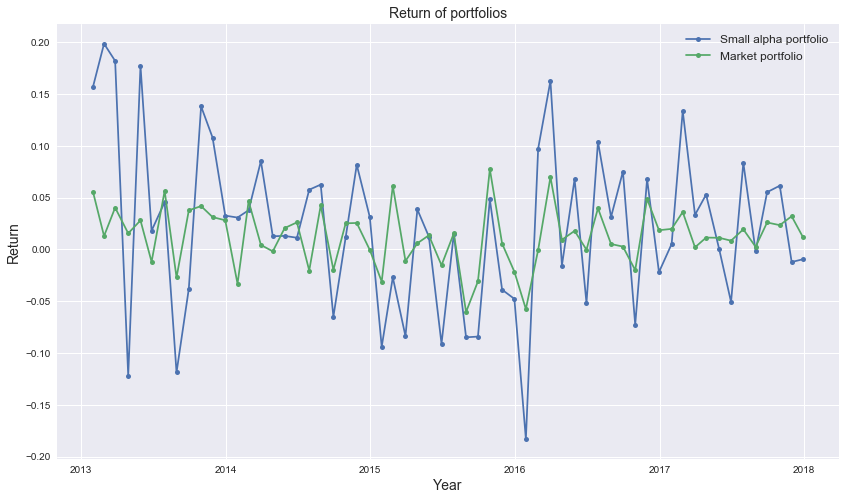

In [72]:
# visualize portfolios' return
plt.style.use('seaborn')
plt.figure(figsize=(14, 8))
plt.plot(temp_result["Small alpha portfolio"], label="Small alpha portfolio", marker=".", ms=10)
plt.plot(temp_result["Market portfolio"], label="Market portfolio", marker=".", ms=10)
plt.title("Return of portfolios", size=14)
plt.xlabel("Year", size=14)
plt.ylabel("Return", size=14)
plt.legend(fontsize=12);

From the table and figure above, we can find that small $\alpha$ portfolio is more volatile than market portfolio, and its average return is also higher than market portfolio, which exceed our expectation.

**Comparison between big $\alpha$ portfolio and market portfolio:**

In [73]:
# select data which lie between 2013~2017
temp_result = big_alpha_result[(small_alpha_result.DATE > date_start) & 
                                 (small_alpha_result.DATE <= date_end)]

# set "DATE" column as index(it will be convenient for plotting)
temp_result.index = temp_result.DATE

# select columns
temp_result = temp_result[["VWPRet", "RM"]]

# rename columns 
temp_result.columns = ["Big alpha portfolio", "Market portfolio"]

# comparison of big alpha portfolio and market portfolio
temp_result.describe().T

,count,mean,std,min,25%,50%,75%,max
Big alpha portfolio,60.0,0.010969,0.054918,-0.123795,-0.026436,0.009284,0.039217,0.126064
Market portfolio,60.0,0.012823,0.028548,-0.060400,-0.000525,0.013250,0.028875,0.077500


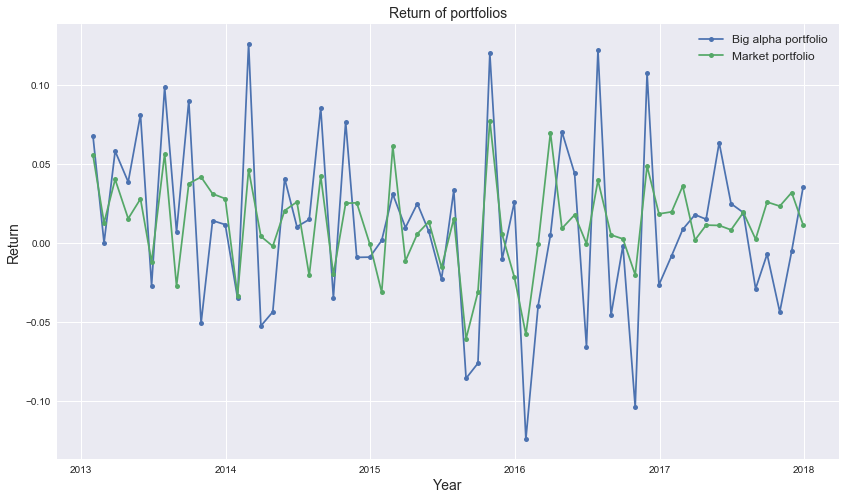

In [74]:
# visualize portfolios' return
plt.style.use('seaborn')
plt.figure(figsize=(14, 8))
plt.plot(temp_result["Big alpha portfolio"], label="Big alpha portfolio", marker=".", ms=10)
plt.plot(temp_result["Market portfolio"], label="Market portfolio", marker=".", ms=10)
plt.title("Return of portfolios", size=14)
plt.xlabel("Year", size=14)
plt.ylabel("Return", size=14)
plt.legend(fontsize=12);

From the table and figure above, we can find that big 𝛼 portfolio is more volatile than market portfolio, and its average return is smaller than market portfolio, which exceed our expectation.

### 5. Do you get the benefit from the portfolio with a big $\alpha$? If you do, how much do you think this result stems from good luck? If you don’t, what do you think went wrong?

In [77]:
# comparison of big alpha portfolio and market portfolio
temp_result.describe().T

,count,mean,std,min,25%,50%,75%,max
Big alpha portfolio,60.0,0.010969,0.054918,-0.123795,-0.026436,0.009284,0.039217,0.126064
Market portfolio,60.0,0.012823,0.028548,-0.060400,-0.000525,0.013250,0.028875,0.077500


We didn't get the benefit from the big $\alpha$ portfolio, its average return is smaller than market portfolio. Although big $\alpha$ portfolio's risk-adjusted abnormal return is significantly bigger than 0 in 2008~2012. However, past performance doesn't guarantee future performance, because both $\alpha$ and $\beta$ will change with time.


(From the section of hypothesis testing above, we can find that big $\alpha$ portfolio's return is insignificantly different(under 95% confidence level) from the volatility of market portfolio's return after 2013. However, if we decrease confidence level to 90%, then this portfolio's $\beta$ will become significantly different from 1, in this case 1.29, which means this portfolio's return is more volatile than market portfolio's return after 2013(under 90% confidence level).) (beta不等於1時，報酬可高於或高於市場投組，而低報酬多過於市場投組時表現就很差)

### 6. We can employ a long-short strategy by longing the portfolio with a large $\alpha$ and shorting the other one. Since both portfolios have a $\beta$ close to 1, this strategy basically gives you a zero-cost portfolio in theory (you actually have to pay transaction costs and the interests due to borrowing stocks), and you bear almost no market risk yet still have a positive $\alpha$. That $\alpha$ is supposed to be your ‘excess return’ (the difference of the returns on the big $\alpha$ portfolio and the small $\alpha$ portfolio) from the strategy. Do you get a positive return over this period (2013-2017) with said strategy?

### 7. Using rolling window regressions with 36 months each window to show how the $\alpha$ and $\beta$ changed for your portfolios from 2013/01-2015/12 to 2015/01-2017/12. Please present the results in graphs.

https://sebastianraschka.com/Articles/2014_ipython_internal_links.html